# Part 1 - Transformations (18)

- Notebook contains exercises on transformations. In particular, we apply transformations to objects and cameras to see what happens on the plane image.

Since we will use a camera model during this exercise, you can choose whether to work on this part now, or after completing the second part of the exercise ([ Part 2: Point Cloud Projection](../README.md#part-2-point-cloud-projection))

**Goal**: The goal of this section is to develop a deeper understanding of the camera projection principles, and of 3D transformations. We will visualize the world and camera frame, 3D objects and their 2D projections. By manipulating 3D objects and observing changes in 2D projection, you will gain better understanding of the camera models.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from utils import ReferenceFrame, Polygon, PrincipalAxis, Image, ImagePlane, \
    get_rotation_matrix, get_projection_matrix
%matplotlib ipympl

## 3.1 - Getting familiar with camera pose and projection (6 Points)

In the code below, we provide examples to draw 3D polygons and their 2D projections given camera parameters. We have drawn two rectangles, the image plane, camera coordinate and 2D projections. Try to read and understand the code.
1. Draw a third rectangle of size 2x3 that is parallel to the y-z plane and the 2D projection should be visible from the image. Compare the projections of three axis-aligned rectangles, what are the differences? **(2 Points)**
2. Play around with the camera rotation parameters (THETA_X/Y/Z), e.g. rotate by one axis by 30 degrees. What happens to the 2D projections when you rotate the camera? **(2 Points)**
3. Play around with the camera translation parameters (C). Move it along x or y or z axis by 3 units. What happens to the 2D projections? **(2 Points)**


**WRITE YOUR ANSWER HERE**
1. Red rectangle is parallel to the yz-plane of both the world and the camera frame.
Green rectangle is parallel to the xz-plane of the world frame but the xy-plane of the camera frame.
Purple rectangle is parallel to the xy-plane of the world frame but the xz-plane of the camera frame.

  We call the distance along the z-axis of the camera frame depth.
Thus the green rectangle, as it is perpendicular to the z axis of the camera frame, its sides continue to be parallel as all the points are at the same depth.
The red rectangle, however, is deformed as the points x1 and x2 are at the same depth but x3 and x4 have a lower depth, thus they also appear farther apart.
The same reasoning holds for the purple rectangle, its points x1 and x4 are closer to the camera while x2 and x3 are farther.

2. Since the rotations use the world frame axes, when rotating about y (which is z in the camera frame, or the optical axis) there is no distortion in any of the rectangles and it is as if we had rotated the 2d image inside its own plane. However, for the other two case, the depths change and for instance the green rectangle is distorted as it is no longer perpendicular to the z-axis.

3. Again since, the world coordinate y-axis is the camera's optical axis if we change y's translation parameter we zoom out (by getting farther from the scene (negative change) or zoom in. Changes to the x or z axis shift the rectangles but are not the same as shifting the original image as in this case occlusions may happen.

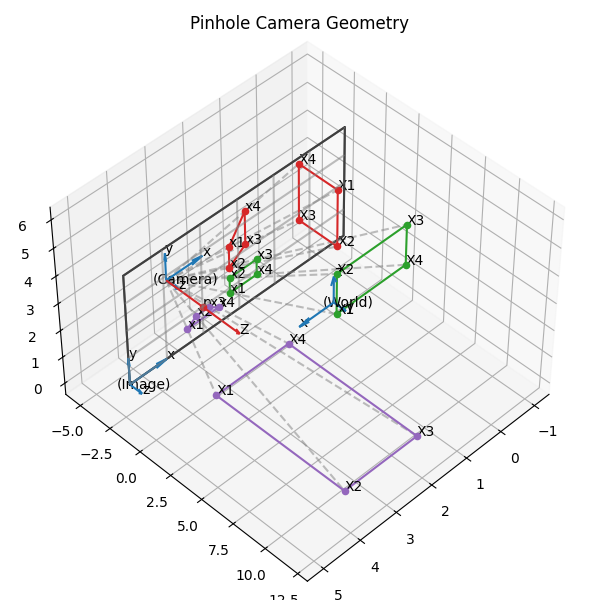

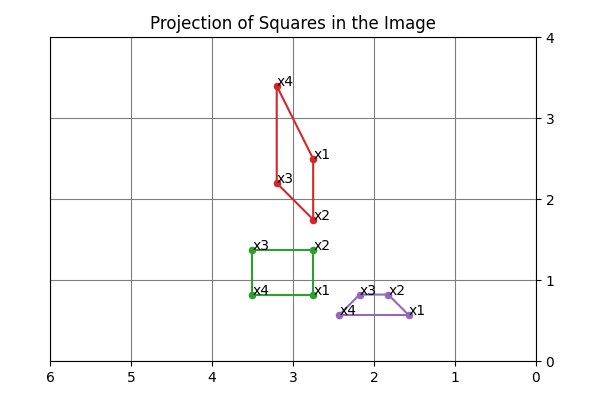

In [6]:
def draw_rectangles(theta_x, theta_y, theta_z, cam_center):
    # camera projection parameters (intrinsics)
    FOCAL_LENGTH = 3.0  # focal length
    PX, PY = 2.0, 1.0  # principal point x and y-coordinate
    MX, MY = 1.0, 1.0  # number of pixels per unit distance in image coordinates in x or y direction

    IMAGE_HEIGTH, IMAGE_WIDTH = 4, 6

    calibration_kwargs = {"f": FOCAL_LENGTH, "px": PX, "py": PY, "mx": MX, "my": MY}
    rotation_kwargs = {"theta_x": theta_x, "theta_y": theta_y, "theta_z": theta_z}
    projection_kwargs = {**calibration_kwargs, **rotation_kwargs, "C": cam_center}

    R = get_rotation_matrix(**rotation_kwargs)
    P = get_projection_matrix(**projection_kwargs)

    # create frames
    dx, dy, dz = np.eye(3)
    world_frame = ReferenceFrame(origin=np.zeros(3), dx=dx, dy=dy, dz=dz, name="World")
    camera_frame = ReferenceFrame(origin=cam_center, dx=R @ dx, dy=R @ dy, dz=R @ dz, name="Camera")
    Z = PrincipalAxis(camera_center=cam_center, camera_dz=camera_frame.dz, f=FOCAL_LENGTH)
    image_frame = ReferenceFrame(origin=Z.p - camera_frame.dx * PX - camera_frame.dy * PY,
        dx=R @ dx, dy=R @ dy, dz=R @ dz, name="Image")
    image_plane = ImagePlane(origin=image_frame.origin, dx=image_frame.dx, dy=image_frame.dy,
        heigth=IMAGE_HEIGTH, width=IMAGE_WIDTH, mx=MX, my=MY)
    image = Image(heigth=IMAGE_HEIGTH, width=IMAGE_WIDTH)

    # create two 3D rectangle
    rect1 = Polygon(np.array([
        [1.0, 3.0, 1.5],
        [1.0, 3.0, 3.0],
        [-1.0, 3.0, 3.0],
        [-1.0, 3.0, 1.5],
    ])) # a rectangle parallel to the image plane
    rect2 = Polygon(np.array([
        [4., 2.0, 1.0],
        [4.0, 12.0, 1.0],
        [2.0, 12.0, 1.0],
        [2.0, 2.0, 1.0]
    ])) # a rectangle perpendicular to the image plane

    ########################################################################################
    # TODO: add a third rectangle that is parallel to the y-z plane of world frame and the #
    #       2D projection should be visible from the image.                                #
    ########################################################################################
    
    rect3 = Polygon(np.array([
        [1.0, 3.0, 6.0],
        [1.0, 3.0, 4.0],
        [1.0, 0.0, 4.0],
        [1.0, 0.0, 6.0]
    ])) # a rectangle parallel to the y-z plane of world frame

    # 3d plot
    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection="3d")
    world_frame.draw3d()
    camera_frame.draw3d()
    image_frame.draw3d()
    Z.draw3d()
    image_plane.draw3d()
    rect1.draw3d(pi=image_plane.pi, C=cam_center)
    rect2.draw3d(pi=image_plane.pi, C=cam_center, color="tab:purple")
    rect3.draw3d(pi=image_plane.pi, C=cam_center, color="tab:red")

    ax.view_init(elev=45.0, azim=45.0)
    ax.set_title("Pinhole Camera Geometry")
    plt.tight_layout()
    plt.show()

    # 2d projection
    fig = plt.figure(figsize=(IMAGE_WIDTH, IMAGE_HEIGTH))
    ax = fig.gca()
    image.draw()
    rect1.draw(**projection_kwargs)
    rect2.draw(**projection_kwargs, color="tab:purple")
    rect3.draw(**projection_kwargs, color="tab:red")

    ax.set_title("Projection of Squares in the Image")
    ax.invert_xaxis()
    ax.yaxis.tick_right()
    plt.tight_layout()
    plt.show()

# camera pose parameters (extrinsics)
THETA_X = np.pi / 2.0  # roll angle
THETA_Y = 0.0  # pitch angle
THETA_Z = np.pi  # yaw angle
C = np.array([3, -5, 2])  # camera centre

draw_rectangles(THETA_X, THETA_Y, THETA_Z, C)

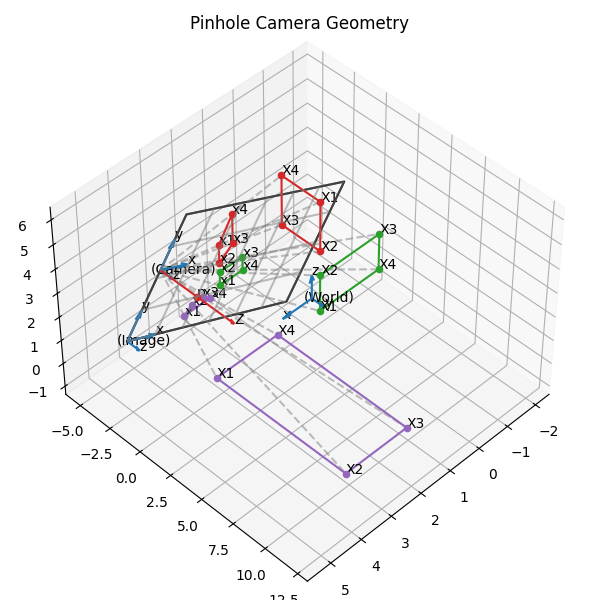

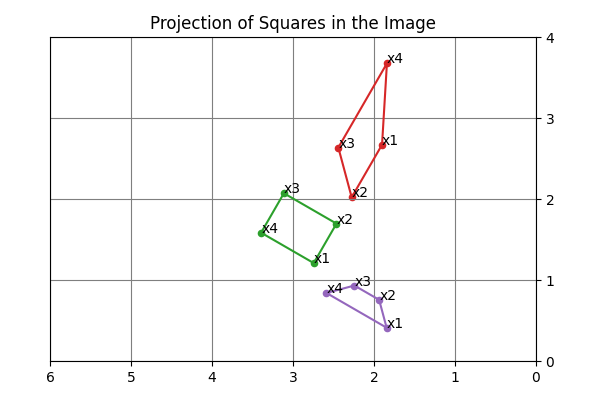

In [ ]:
########################################################################################
# TODO: draw the same scene changing only Camera rotation                              #
########################################################################################

draw_rectangles(THETA_X, THETA_Y + np.radians(30), THETA_Z, C)


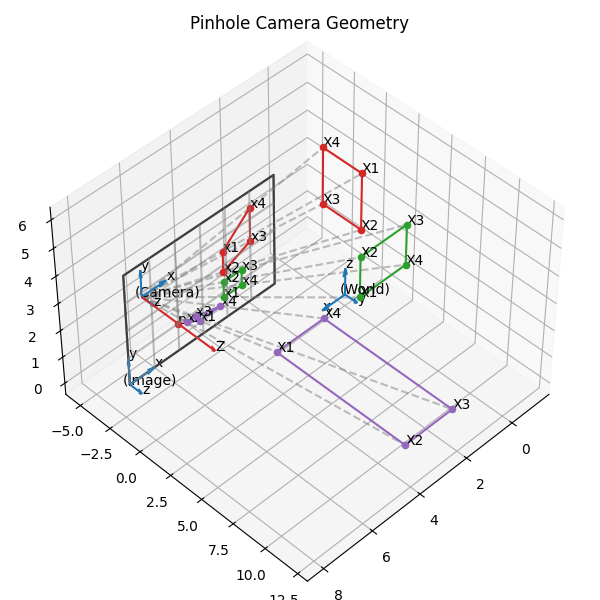

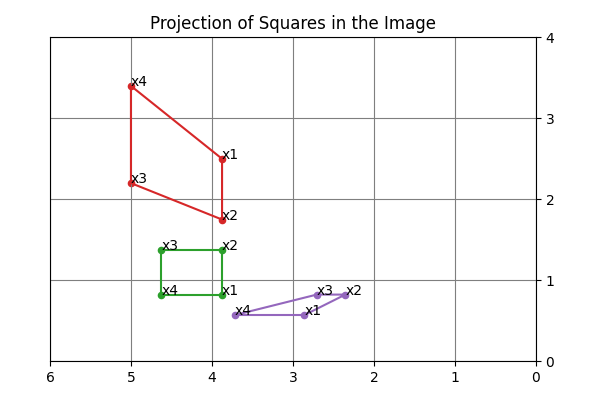

In [ ]:
########################################################################################
# TODO: draw the same scene changing only Camera translation (centre point)            #
########################################################################################

draw_rectangles(THETA_X, THETA_Y, THETA_Z, C + np.array([3,0,0])) # move the camera along the x-axis by 3 units

There are multiple ways to change how a 3D object appears in a 2D image. For example, one can change the camera pose (extrinsics), camera projection parameter (intrinsics) or manipulate the 3D object by rotation, translation and scale. 

Here we will further explore object pose manipulation.

## 3.2 - Manipulating 3D object pose **(6 Point)**
In the figure below, we draw a cube in 3D and place a camera at a random location. The 3D cube is projected as a tilted box in the image.

Can you find a transformation applied to the 3D cube such that the cube is projected in the image as an axis aligned square of size 2x2?

Note that here you are allowed to change only the 3D cube pose parameters, i.e. only rotation, translation and no non-rigid deformation. The camera parameters should remain the same.
How many unique solutions are there for this question? Provide one such solution with their corresponding 2D projection image.

Hint: you can first find the transformation to align the 3D cube with the world coordinate axis, then adjust the translation to obtain desired width.

---
**WRITE YOUR ANSWER HERE**

We use the points of the cube to get two orthogonal vectors in the plane of the cubic front. That is we choose 3 adjacent points and subtract the middle one from the other two as to get two vectors with origin in the middle point. Then, we take the cross product of these two and end up with three orthogonal vectors which form the basis for the coordinate frame of the cube. These can be used as the columns of the rotational matrix when normalized.

Then, since there are 4 ways of choosing the vectors for each point and there are 8 points in a cube there are 32 possible unique solutions.

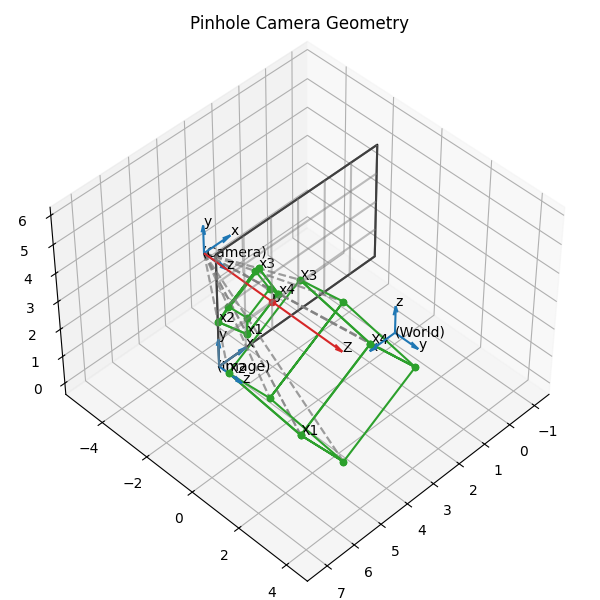

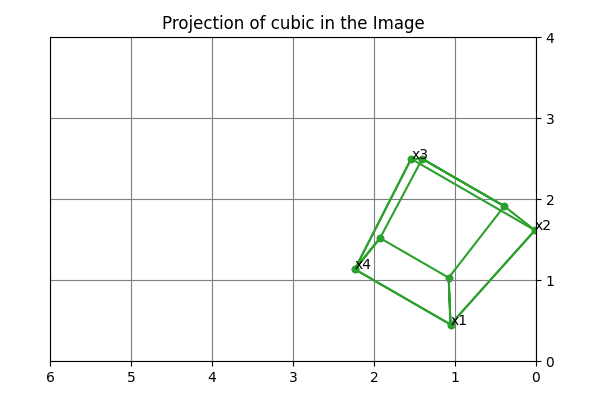

In [ ]:
def draw_cube(theta_x, theta_y, theta_z, cam_center, focal_length,
              principal_x, principal_y,
               cube_verts):
    # camera projection parameters (intrinsics)
    FOCAL_LENGTH = focal_length  # focal length
    PX, PY = principal_x, principal_y  # principal point x and y-coordinate
    MX, MY = 1.0, 1.0  # number of pixels per unit distance in image coordinates in x or y direction

    IMAGE_HEIGTH, IMAGE_WIDTH = 4, 6

    calibration_kwargs = {"f": FOCAL_LENGTH, "px": PX, "py": PY, "mx": MX, "my": MY}
    rotation_kwargs = {"theta_x": theta_x, "theta_y": theta_y, "theta_z": theta_z}
    projection_kwargs = {**calibration_kwargs, **rotation_kwargs, "C": cam_center}

    R = get_rotation_matrix(**rotation_kwargs)

    # create frames
    dx, dy, dz = np.eye(3)
    world_frame = ReferenceFrame(origin=np.zeros(3), dx=dx, dy=dy, dz=dz, name="World")
    camera_frame = ReferenceFrame(origin=cam_center, dx=R @ dx, dy=R @ dy, dz=R @ dz, name="Camera")
    Z = PrincipalAxis(camera_center=cam_center, camera_dz=camera_frame.dz, f=FOCAL_LENGTH)
    image_frame = ReferenceFrame(origin=Z.p - camera_frame.dx * PX - camera_frame.dy * PY,
        dx=R @ dx, dy=R @ dy, dz=R @ dz, name="Image")
    image_plane = ImagePlane(origin=image_frame.origin, dx=image_frame.dx, dy=image_frame.dy,
        heigth=IMAGE_HEIGTH, width=IMAGE_WIDTH, mx=MX, my=MY)
    image = Image(heigth=IMAGE_HEIGTH, width=IMAGE_WIDTH)

    # create a cubic
    verts = cube_verts
    cubic_front = Polygon(verts[:4])
    cubic = Polygon(verts[4:])
    # cubic_back = Polygon(verts[-4:])

    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection="3d")
    world_frame.draw3d()
    camera_frame.draw3d()
    image_frame.draw3d()
    Z.draw3d()
    image_plane.draw3d()
    cubic_front.draw3d(pi=image_plane.pi, C=C)
    cubic.draw3d(pi=image_plane.pi, C=C, notext=True)

    ax.view_init(elev=45.0, azim=45.0)
    ax.set_title("Pinhole Camera Geometry")
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(IMAGE_WIDTH, IMAGE_HEIGTH))
    ax = fig.gca()
    image.draw()
    cubic_front.draw(**projection_kwargs)
    cubic.draw(**projection_kwargs, notext=True)
    ax.set_title("Projection of cubic in the Image")
    ax.invert_xaxis()
    ax.yaxis.tick_right()
    plt.tight_layout()
    plt.show()

### The camera parameters, these should be FIXED!
THETA_X = np.pi / 2.0  # roll angle
THETA_Y = 0.0  # pitch angle
THETA_Z = np.pi  # yaw angle
C = np.array([3, -5, 2.])  # camera centre
focal_length = 3
principal_x, principal_y = 2., 1.

cube_file = "../data/cubic_verts.txt"
cube_verts = np.loadtxt(cube_file)

draw_cube(THETA_X, THETA_Y, THETA_Z, C, focal_length, principal_x, principal_y, cube_verts)

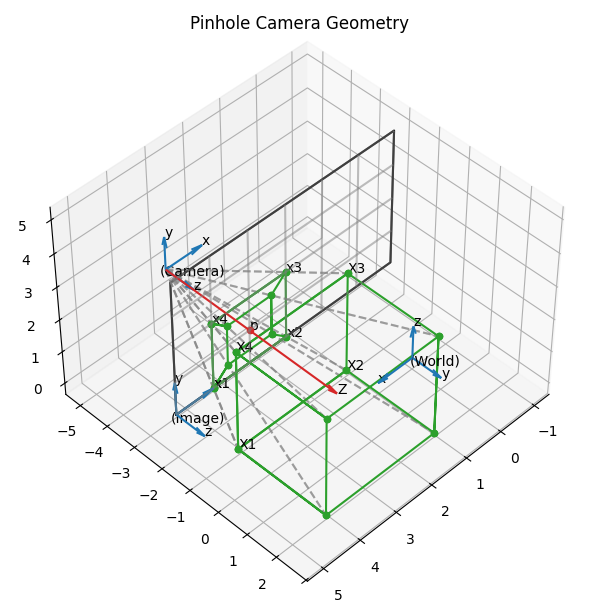

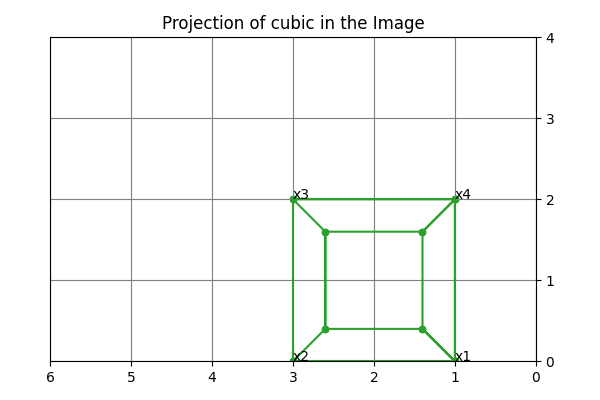

In [10]:
cube_file = "../data/cubic_verts.txt"
verts = np.loadtxt(cube_file)

cubic_front = Polygon(verts[:4])
cubic = Polygon(verts[4:])

def normalize(vect):
    "normalize a vector: divide by its length"
    return vect / np.linalg.norm(vect)

########################################################################################
# TODO: find proper transformation to the cubic vertices such that it's front (x1-x4)  #
#       is projected as a square of size 2 in the image. Transformation is R and t.    #
# HINT: - construct a local coordinate frame using cube's edges and align it with      #
#         global coordinate frame;                                                     #
#       - change the depth of the cube such that length of edge's projection is 2      #
#         (fx * length / dist = pixel_width)                                           #
#       - align the front face of the cube with the image plane and shift it using     #
#         the distance friom the previous step;                                        #
########################################################################################
u1, u2, u3 = verts[:3]
u1, u3 = u1-u2, u3-u2
u1, u3 = normalize(u1), normalize(u3)
u2 = np.cross(u1, u3)
R = np.block([[u1],[u2],[u3]])
rotated_verts = (R@verts.T).T

rotated_verts[:,2] += np.ones_like(rotated_verts[:,2]) * 4.5
rotated_verts[:,0] += np.ones_like(rotated_verts[:,0]) * 6.5
# length of cube is 3, fx is 3, pixel_width is 1 so depth should be 1.5
# image plane is at y = -2 and our cubic_front at 3 so we subtract 3.5
rotated_verts[:,1] -= np.ones_like(rotated_verts[:,1]) * 3.5

draw_cube(THETA_X, THETA_Y, THETA_Z, C, focal_length, principal_x, principal_y, rotated_verts)

## 3 - Manipulating camera projection parameters **(4 Points)**
Now let us fix the camera pose and play with the projection parameters. Using the transformation to the cubic vertices you find above, can you change only the focal length and camera principal point, such that the square is projected to the center of the image, and:
1. The square size is doubled **(0.5 Points)**? or
2. The square size is halved **(0.5 Points)**?

Report your results and corresponding 2D projection image.

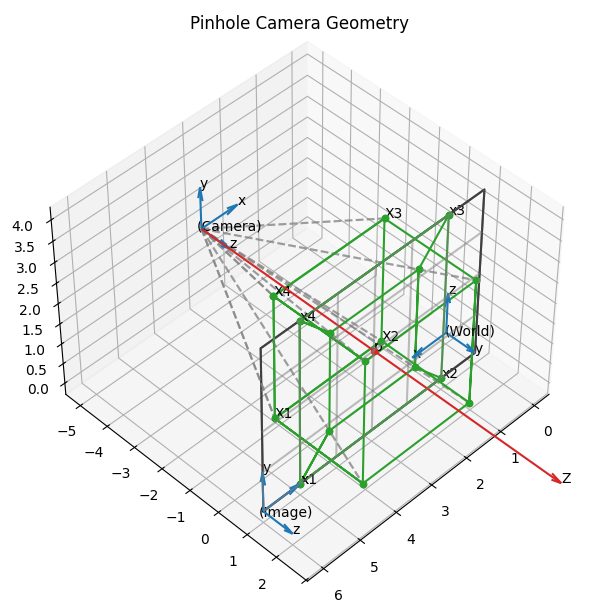

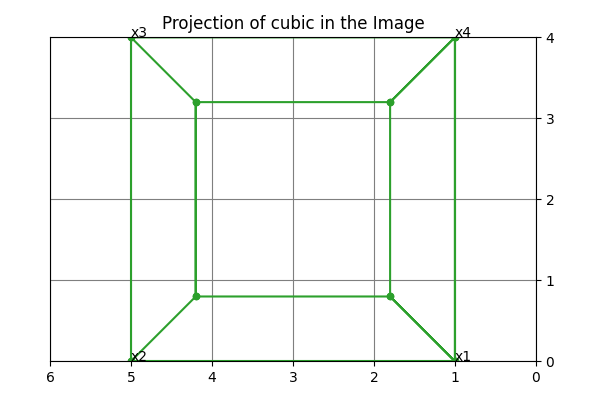

In [12]:
### Some camera parameters that should be fixed
THETA_X = np.pi / 2.0  # roll angle
THETA_Y = 0.0  # pitch angle
THETA_Z = np.pi  # yaw angle
C = np.array([3, -5, 2.])  # camera centre

########################################################################################
# TODO: find camera focal, principal point such that the square size is doubled (4px)  #
#       and the square is centered in the image                                        #
########################################################################################
draw_cube(THETA_X, THETA_Y, THETA_Z, C, 6, principal_x+1, principal_y+1, rotated_verts)

/tmp/ipykernel_206133/1931264111.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(6, 6))


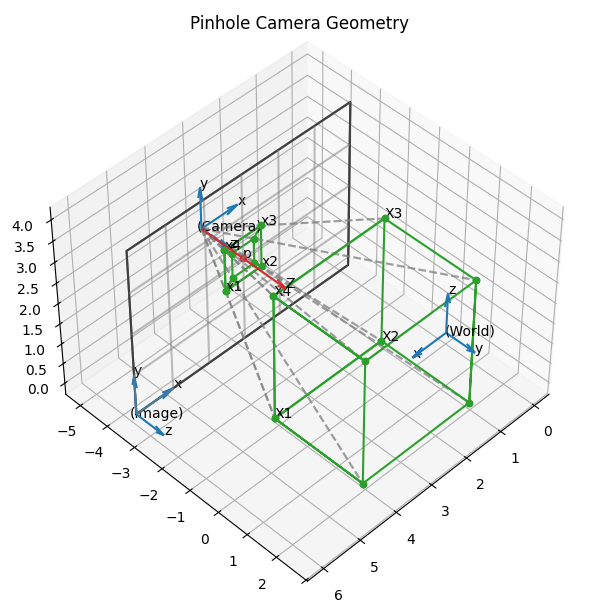

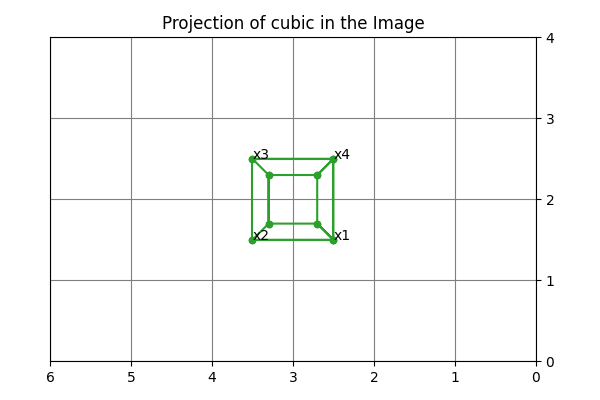

In [13]:
### Some camera parameters that should be fixed
THETA_X = np.pi / 2.0  # roll angle
THETA_Y = 0.0  # pitch angle
THETA_Z = np.pi  # yaw angle
C = np.array([3, -5, 2.])  # camera centre

########################################################################################
# TODO: find camera focal, principal point such that the square size is halved (1px)   #
#       and the square is centered in the image                                        #
########################################################################################
draw_cube(THETA_X, THETA_Y, THETA_Z, C, 1.5, principal_x+1, principal_y+1, rotated_verts)

## 3.4 – Estimating Depth from Size in Image **(2 Points)**

In this exercise, we explore how the apparent size of an object in the image relates to its depth (distance from the camera). When using a pinhole camera, the size of an object in pixels decreases as it moves farther away from the camera.

We will draw several identical squares placed at different depths and analyze their image projections. Then, you will derive a simple formula that estimates the depth of an object based on its size in the image.

Exercise

1. Run the cell below. It draws three identical squares at increasing distances from the camera.
2. Observe how the projected square size changes with depth.
3. Use the projection equation to derive the formula:
    - $\text{ImageWidth} = (\text{FocalLength} * \text{RealWidth}) / \text{Depth}$
4. Invert the formula to estimate the depth of a square from its projected size in the image.
5. Implement the function `estimate_depth_from_size` below and use it to compute the depth of each projected square.
6. Compare your estimated depths with the ground-truth depths used to render the scene. Are they close?

**WRITE YOUR ANSWER HERE** 

3. The basic perspective projection equation goes as:
$x = f\frac{X}{Z}$ where $x$ is the image coordinate, $f$ is the focal length, $X$ is the world coordinate, and $Z$ is the depth. If one replaces $x$ by ImageWidth and $X$ by RealWidth we get the equation in step 2 above.

4. Solving for depth gives:
$ \text{Depth} = (\text{FocalLength} * \text{RealWidth}) / \text{ImageWidth}$.

6.They are close! And the test is passing :D

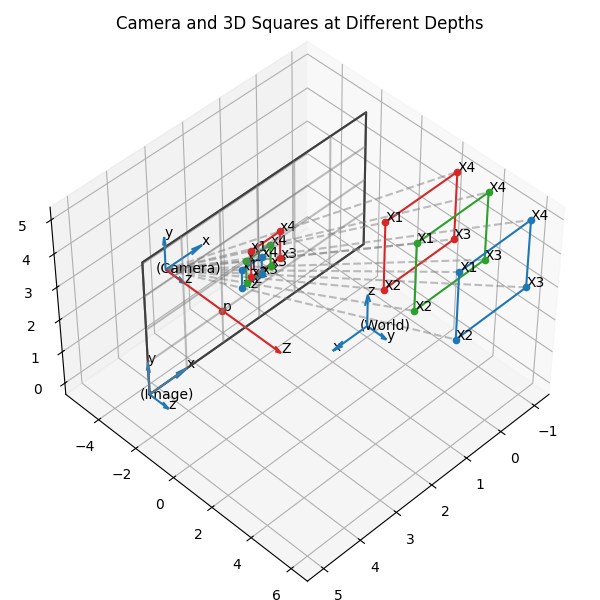

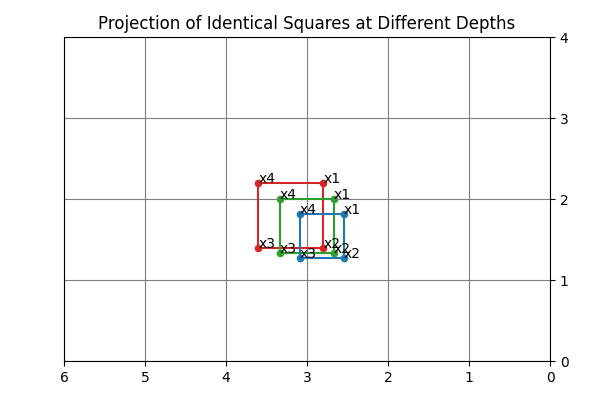

------------------------


In [18]:
def draw_squares_and_estimate_depth_fixed_with_3d():
    # Camera parameters
    focal_length = 3.0
    px, py = 2.0, 1.0
    mx, my = 1.0, 1.0
    image_width, image_height = 6, 4

    calibration_kwargs = {"f": focal_length, "px": px, "py": py, "mx": mx, "my": my}
    theta_x, theta_y, theta_z = np.pi / 2.0, 0.0, np.pi
    cam_center = np.array([3, -5, 2])
    rotation_kwargs = {"theta_x": theta_x, "theta_y": theta_y, "theta_z": theta_z}
    projection_kwargs = {**calibration_kwargs, **rotation_kwargs, "C": cam_center}

    R = get_rotation_matrix(**rotation_kwargs)

    # Reference frames
    dx, dy, dz = np.eye(3)
    world_frame = ReferenceFrame(origin=np.zeros(3), dx=dx, dy=dy, dz=dz, name="World")
    camera_frame = ReferenceFrame(origin=cam_center, dx=R @ dx, dy=R @ dy, dz=R @ dz, name="Camera")
    Z = PrincipalAxis(camera_center=cam_center, camera_dz=camera_frame.dz, f=focal_length)
    image_frame = ReferenceFrame(origin=Z.p - camera_frame.dx * px - camera_frame.dy * py,
                                 dx=R @ dx, dy=R @ dy, dz=R @ dz, name="Image")
    image_plane = ImagePlane(origin=image_frame.origin, dx=image_frame.dx, dy=image_frame.dy,
                             heigth=image_height, width=image_width, mx=mx, my=my)

    # Square definitions
    depths = [2.5, 4.0, 6.0]  # known 3D depths
    real_width = 2.0  # side length of each square
    colors = ["tab:red", "tab:green", "tab:blue"]

    squares = []
    for z in depths:
        square = Polygon(np.array([
            [real_width/2, z, 4.0 + real_width/2],
            [real_width/2, z, 4.0 - real_width/2],
            [-real_width/2, z, 4.0 - real_width/2],
            [-real_width/2, z, 4.0 + real_width/2]
        ]))
        squares.append(square)

    # Draw 3D scene
    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection="3d")
    world_frame.draw3d()
    camera_frame.draw3d()
    image_frame.draw3d()
    image_plane.draw3d()
    Z.draw3d()

    for sq, color in zip(squares, colors):
        sq.draw3d(pi=image_plane.pi, C=cam_center, color=color)

    ax.view_init(elev=45.0, azim=45.0)
    ax.set_title("Camera and 3D Squares at Different Depths")
    plt.tight_layout()
    plt.show()

    # Draw 2D projections
    image = Image(heigth=image_height, width=image_width)
    fig = plt.figure(figsize=(image_width, image_height))
    ax = fig.gca()
    image.draw()
    for sq, color in zip(squares, colors):
        sq.draw(**projection_kwargs, color=color)
    ax.set_title("Projection of Identical Squares at Different Depths")
    plt.tight_layout()
    ax.invert_xaxis()
    ax.yaxis.tick_right()
    plt.show()


    #############################################################################################
    # TODO: Complete the depth estimation code below                                            #
    #                                                                                           #
    # Instructions:                                                                             #
    # - Write a function `estimate_depth_from_size(f, real_width, pixel_width)` that uses the   #
    #   pinhole projection model to calculate depth.                                            #
    # - For each square:                                                                        #
    #   - Project its corners to image space. (use the `project` method for squares to get      #
    #     the projection).                                                                      #
    #   - Measure the projected size (pixel width).                                             #
    #   - Estimate the depth using the  `estimate_depth_from_size` function.                    #
    #   - Print out the estimated vs true depths.                                               #    
    # - Use the provided assertion to compare your estimated depths with the expected ones.     #
    #############################################################################################
    def estimate_depth_from_size(f, real_width, pixel_width):
        """
        Estimate the depth of an object given the focal length, the real width of the object and the pixel width of the object.
        """
        return f*real_width/pixel_width

    estimated_depths = []
    for i, sq in enumerate(squares):
        corners_img = sq.project(**projection_kwargs)
        pixel_width = np.linalg.norm(corners_img[1] - corners_img[0])
        estimated_depth = estimate_depth_from_size(focal_length, real_width, pixel_width)
        estimated_depths.append(estimated_depth)
    
    print("------------------------")
    # Don't touch this code. 
    # Check if estimated depths are close to expected depths. 
    # If the assert fails, it means that your depth estimation is not correct.
    expected_depths = [d - cam_center[1] for d in depths] # The gt depth considers the camera center
    assert np.allclose(estimated_depths, expected_depths, atol=0.001), f"Depth estimation failed! - {estimated_depths} != {expected_depths}"

draw_squares_and_estimate_depth_fixed_with_3d()